# Titanic Torch 🔥

![https://www.maritimecyprus.com/wp-content/uploads/2015/10/titanic-infographic-1536x951.jpg](https://www.maritimecyprus.com/wp-content/uploads/2015/10/titanic-infographic-1536x951.jpg)

This notebook aims to solve the titanic classification problem using `pytorch`

## Imports

In [1]:
# Data agg
import pandas as pd
import numpy as np

# Viz
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.deterministic = True  

# metrics
from sklearn import metrics

# Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data

In [2]:
# compared with dataset from kaggle, the one provided by standford has less features
df = pd.read_csv('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv')
df.columns = df.columns.str.lower().str.replace('/','_').str.replace(' ','_')
# drop. the name
df = df.drop(['name'],axis=1)
# encode the values from the sex column
df.sex = df.sex.replace({
    'male':1,
    'female': 0
})
df[:3]

,survived,pclass,sex,age,siblings_spouses_aboard,parents_children_aboard,fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250


## Modelling

In [3]:
scaler = StandardScaler()

**Set the target and features**


In [4]:
target = 'survived'

features = ['pclass', 'sex', 'age', 'siblings_spouses_aboard','parents_children_aboard', 'fare']

**Apply scaler on features**

In [5]:
df[features] = scaler.fit_transform(df[features])

**Split data into train/test**

In [6]:
train,test = train_test_split(df,test_size=0.33,random_state=42,stratify=df[target])

**From pandas/numpy to Tensors (types are important)**

In [7]:
x_train = torch.from_numpy(train[features].values).type(torch.FloatTensor)
y_train = torch.from_numpy(train[target].values).type(torch.LongTensor)

x_test = torch.from_numpy(test[features].values).type(torch.FloatTensor)
y_test = torch.from_numpy(test[target].values).type(torch.LongTensor)

**Keep this part into one cell, it willl make the model development and testing easier**

Accuracy  : 80.89%
Train loss: 0.4383288621902466
Test loss : 0.4455047845840454


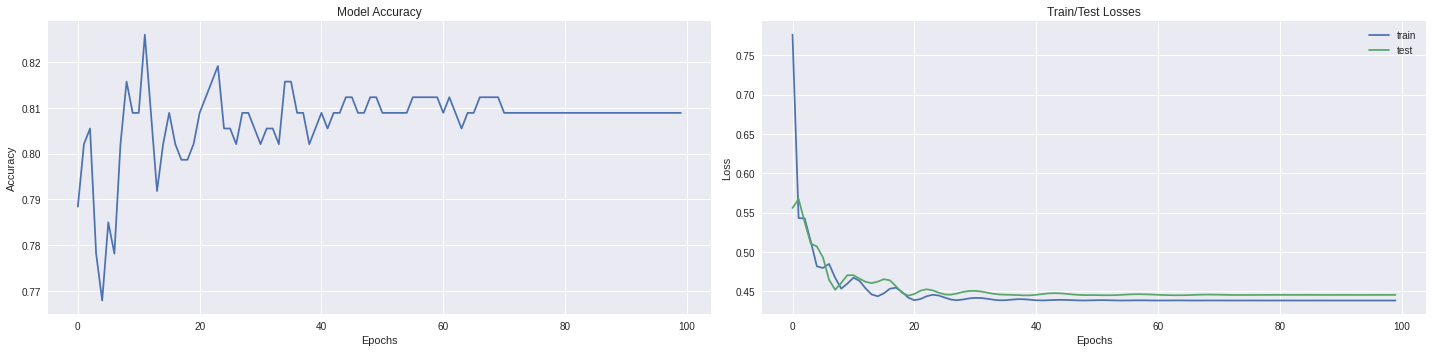

In [8]:
### Here is our neural network
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()
        # takes an imput of 6 features, and spits out a vector of size 256
        self.lin1 = nn.Linear(in_features=6,out_features=256,bias=True)
        # the second layer takes the 256 vector and process it into a vector of size 64
        self.lin2 = nn.Linear(in_features=256,out_features=64,bias=True)
        # the last layer takes the 64 size vector and returns the output vector which 2 == number of classes
        self.lin3 = nn.Linear(in_features=64,out_features=2,bias=True)
    
    # here we take the input data and pass it through the chain of layers
    def forward(self,input):
        x = self.lin1(input)
        x = self.lin2(x)
        x = self.lin3(x)
        return x

# instance our model
model = Net()
# set the number of epochs
epochs = 100
# criterion aka loss function -> find more on pytorch doc
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# create 3 lists to store the losses and accuracy at each epoch
train_losses, test_losses, accuracy = [0]*epochs, [0]*epochs,[0]*epochs


# in this current case we don't use batches for training and we pass the whole data at each epoch
for e in range(epochs):
    optimizer.zero_grad()

    # Comput train loss
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    
    loss.backward()

    optimizer.step()

    # store train loss
    train_losses[e] = loss.item()
    
    # Compute the test stats
    with torch.no_grad():
        # Turn on all the nodes
        model.eval()
        
        # Comput test loss
        ps = model(x_test)
        loss = criterion(ps, y_test)

        # store test loss
        test_losses[e] = loss.item()
        
        # Compute accuracy
        top_p, top_class = ps.topk(1, dim=1)
    
        equals = (top_class == y_test.view(*top_class.shape))
        
        # store accuracy
        accuracy[e] = torch.mean(equals.type(torch.FloatTensor))

# Print the final information
print(f'Accuracy  : {100*accuracy[-1].item():0.2f}%')
print(f'Train loss: {train_losses[-1]}')
print(f'Test loss : {test_losses[-1]}')
    
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Model Accuracy')
ax[0].plot(accuracy)

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Train/Test Losses')
ax[1].plot(train_losses, label='train')
ax[1].plot(test_losses, label='test')
ax[1].legend()   

plt.tight_layout()

**Classificaiton Report**

In [9]:
print(metrics.classification_report(test[target],top_class.numpy().ravel()))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       180
           1       0.78      0.71      0.74       113

    accuracy                           0.81       293
   macro avg       0.80      0.79      0.79       293
weighted avg       0.81      0.81      0.81       293



**Confusion Matrix**

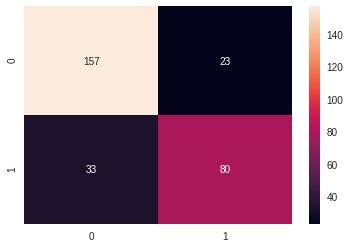

In [10]:
sns.heatmap(metrics.confusion_matrix(test[target],top_class.numpy().ravel()),fmt='d',annot=True)